# Необходимые функции и библиотеки

In [1]:
import numpy as np
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.datasets import make_regression

# графики
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
def make_data(target_func, factors, number_of_points, start_time=0, finish_time=5, shuffle=False, smooth=False):
    """
    Функция для генерации данных
    
    Parameters:
        target_func : (func)
            целевая функция
        factors : (func)
            значения вектора регрессора
        number_of_points : (int)
            число наблюдений, которое надо сгенерировать
        start_time : (float, default=0)
            нижняя граница времени
        finish_time : (float, default=5)
            верхняя граница времени
        shuffle : (bool, default=False)
            в случае True данные будут перемешаны
        smooth : (bool, default=False)
            в случае True данные будут зашумлены (гауссовским шумом)
    
    Return:
        X (numpy.array) : выборка (признаки, значения регрессора в разные моменты времени)
        y (numpy.array) : выборка (целевое значение в разные моменты времени)
    
    """
    time_interval = np.linspace(start_time, finish_time, number_of_points)
    X = np.array([factors(t) for t in time_interval])
    y = np.array([target_func(t) for t in time_interval])
    
    if smooth:
        noise = np.random.normal(0, 1, number_of_points)
        y += noise
    
    if shuffle:
        indexes_for_shuffle = np.arange(len(y))
        np.random.shuffle(indexes_for_shuffle)
        X = X[indexes_for_shuffle]
        y = y[indexes_for_shuffle]
    
    return X, y

# Класс модели, использующей метод динамического расширения и смешивания регрессора

In [4]:
class DREM_model:
    """
    Регрессионная модель, основанная на методе динамического расширения и смешивания регрессора
    
    Parameters:
        lr (float) : коэффициент адаптации
        eps (float) : точность сходимости
        number_of_iter (int) : количество итераций
    
    Methods:
        fit(X: numpy.array, y: numpy.array) : 
                вычисление параметров регрессионной модели
    Notes:
        Для оценивания параметров используется итерационная процедура:
            W(k+1) = W(k) + (lr*det(X)) / (1 + lr*det(X)*det(X)) * (adj(X)*y - det(X)*W(k)) (при len(X)==число признаков)
            W(k+1) = W(k) + intercept/s (при len(X)== (s * число признаков))
            здесь intercept = sum((lr*det(X_i)) / (1 + lr*det(X_i)*det(X_i)) * (adj(X_i)*y_i - det(X_i)*W(k))) для каждой i-ой части (i=1,s)
    """
    def __init__(self, lr, number_of_iter=10000, eps=0.000001):
        self.theta = np.array([])
        self.scores_results = []
        
        self.eps = eps
        self.lr = lr
        self.n_of_iter = number_of_iter
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.theta = np.zeros(n_features)
        
        if n_samples % n_features == 0:
            indexes_for_shuffle = np.arange(len(y))
            np.random.shuffle(indexes_for_shuffle)
            X = X[indexes_for_shuffle]
            y = y[indexes_for_shuffle]
            
            n_batches = n_samples // n_features
            X_shaped = X.reshape(n_batches, n_features, n_features)
            y_shaped = y.reshape(n_batches, n_features)
            
            intercept_of_theta = 0
            for i in range(3*self.n_of_iter):
                patch = i % n_batches
                X_train = X_shaped[patch]
                y_train = y_shaped[patch]
                
                det, inv = np.linalg.det(X_train), np.linalg.pinv(X_train)
                
                left = det * inv.dot(y_train) 
                
                normalize_coef = (self.lr * det)/(1 + self.lr * det**2)
                error = left - det * self.theta
                intercept_of_theta += normalize_coef * error
                
                if i>0 and patch==0:
                    self.theta = self.theta + intercept_of_theta/n_batches
                    intercept_of_theta = 0
                    self.scores_results.append(self.score(X, y))
                    
        else:
            for i in range(self.n_of_iter):
                ##
                indexes = np.random.choice(n_samples, size=n_features)
                X_train = X[indexes]
                y_train = y[indexes]
                det, inv = np.linalg.det(X_train), np.linalg.pinv(X_train)
                left = det * inv.dot(y_train) 
                ##
                normalize_coef = (self.lr * det)/(1 + self.lr * det**2)
                error = left - det * self.theta
                
                
                self.theta = self.theta + normalize_coef * error
                
                ##
                self.scores_results.append(self.score(X, y))
                
    def predict(self, X):
        return X.dot(self.theta)
    
    @property
    def coef_(self):
        return self.theta
    
    def score(self, X, y):
        predicted = self.predict(X)
        r2 = 1 - np.sum((predicted-y)**2)/np.sum((y-y.mean())**2)
        return r2

# Сравниваемые модели

In [5]:
model_ols = LinearRegression()
model_grad = SGDRegressor()
model_drem = DREM_model(lr=0.001, number_of_iter=10000)

# Набор данных

In [6]:
#  регрессор 
regressor = lambda t: np.array([np.sin(0.1*t + np.pi/3),
                                np.sin(3*t + np.pi/2),
                                np.sin(5*t)])
#  целевая функция
target = lambda t: 2 * np.sin(0.1*t + np.pi/3) + 1 * np.sin(3*t + np.pi/2) - 3 * np.sin(5*t)

full_time_interval = np.linspace(0, 500, 50000)

## Без шума

In [7]:
# 50 000 наблюдений: t от 0 до 15 секунд с шагом 0.01
X_full, y_full = make_data(target,
                           regressor,
                           number_of_points=50000,
                           start_time=0,
                           finish_time=500,
                           smooth=False,
                           shuffle=True)

# 500 раз произведем оценивание параметров (в разные промежутки времени)
X_shaped = X_full.reshape(500, 100, 3)
y_shaped = y_full.reshape(500, 100)

## С шумом

In [8]:
# 50 000 наблюдений: t от 0 до 500 секунд с шагом 0.01
X_full_smooth, y_full_smooth = make_data(target,
                                         regressor,
                                         number_of_points=50000,
                                         start_time=0,
                                         finish_time=500,
                                         smooth=True,
                                         shuffle=True)

# 500 раз произведем оценивание параметров (в разные промежутки времени)
X_shaped_smooth = X_full_smooth.reshape(500, 100, 3)
y_shaped_smooth = y_full_smooth.reshape(500, 100)

# Эксперимент

In [9]:
dict_with_results = {'DREM': [], 'Gradient Descent': [], 'Least Squares': []}
dict_with_estimation = {'DREM': [], 'Gradient Descent': [], 'Least Squares': []}
dict_with_score = {'DREM': [], 'Gradient Descent': [], 'Least Squares': []}

## На "чистом" наборе

In [10]:
for name, model in [('Least Squares', model_ols), ('Gradient Descent', model_grad), ('DREM', model_drem)]:
    for i in range(500):
        X_patch = X_shaped[i]
        y_patch = y_shaped[i]
        
        model.fit(X_patch, y_patch)
        dict_with_estimation[name].append(model.coef_)
        dict_with_results[name] += model.predict(X_patch).tolist()

Text(0, 0.5, 'Зависимая переменная y(t)')

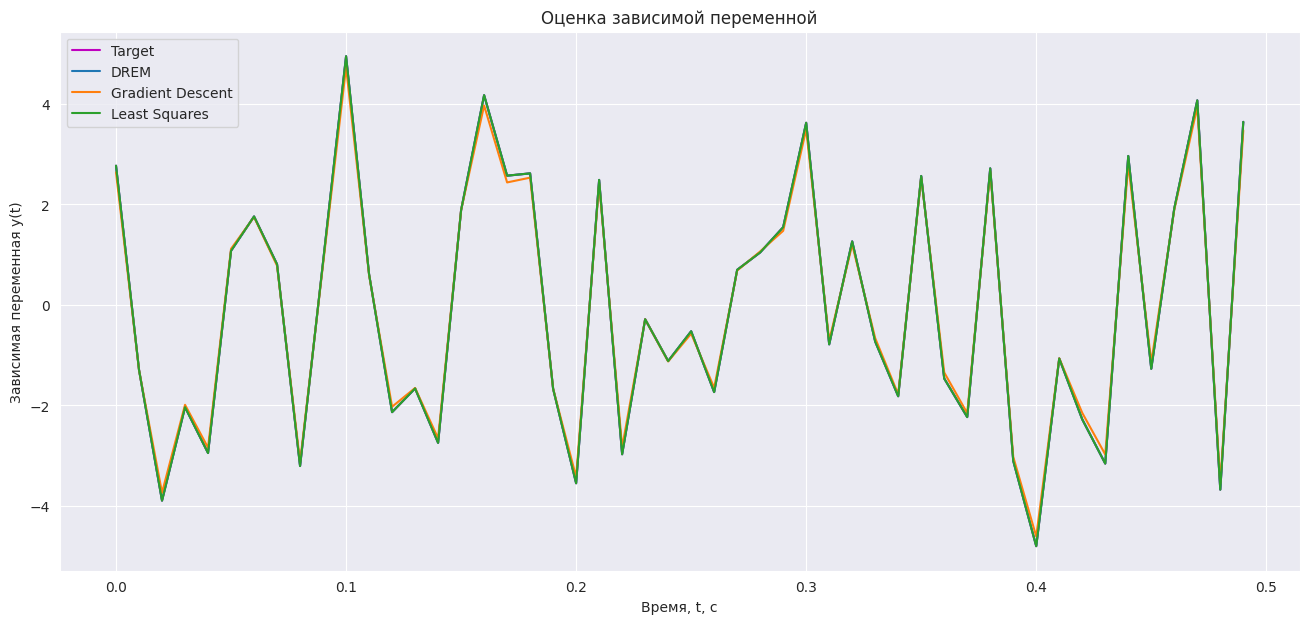

In [11]:
plt.figure(figsize=(16, 7))
plt.plot(full_time_interval[:50], y_full[:50], c='m', label='Target')

for model in dict_with_results:
    plt.plot(full_time_interval[:50], dict_with_results[model][:50], label=model)
    
plt.title('Оценка зависимой переменной')
plt.legend()
plt.xlabel('Время, t, с')
plt.ylabel('Зависимая переменная y(t)')

In [12]:
for model in dict_with_estimation:
    dict_with_estimation[model] = np.vstack(dict_with_estimation[model])

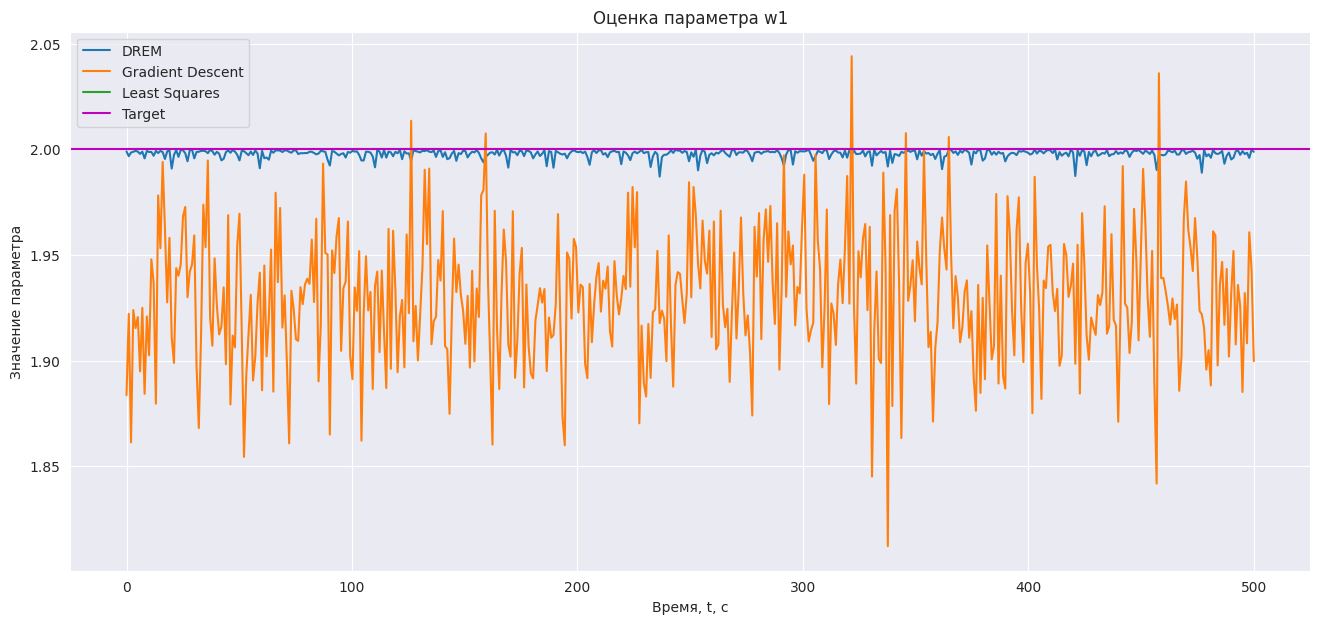

In [13]:
plt.figure(figsize=(16, 7))

for model in dict_with_results:
    plt.plot(np.linspace(0, 500, 500), dict_with_estimation[model][:, 0], label=model)
    
plt.axhline(y=2, xmin=0, xmax=5, c='m', label='Target')
plt.title('Оценка параметра w1')
plt.xlabel('Время, t, с')
plt.ylabel('Значение параметра')
plt.legend()

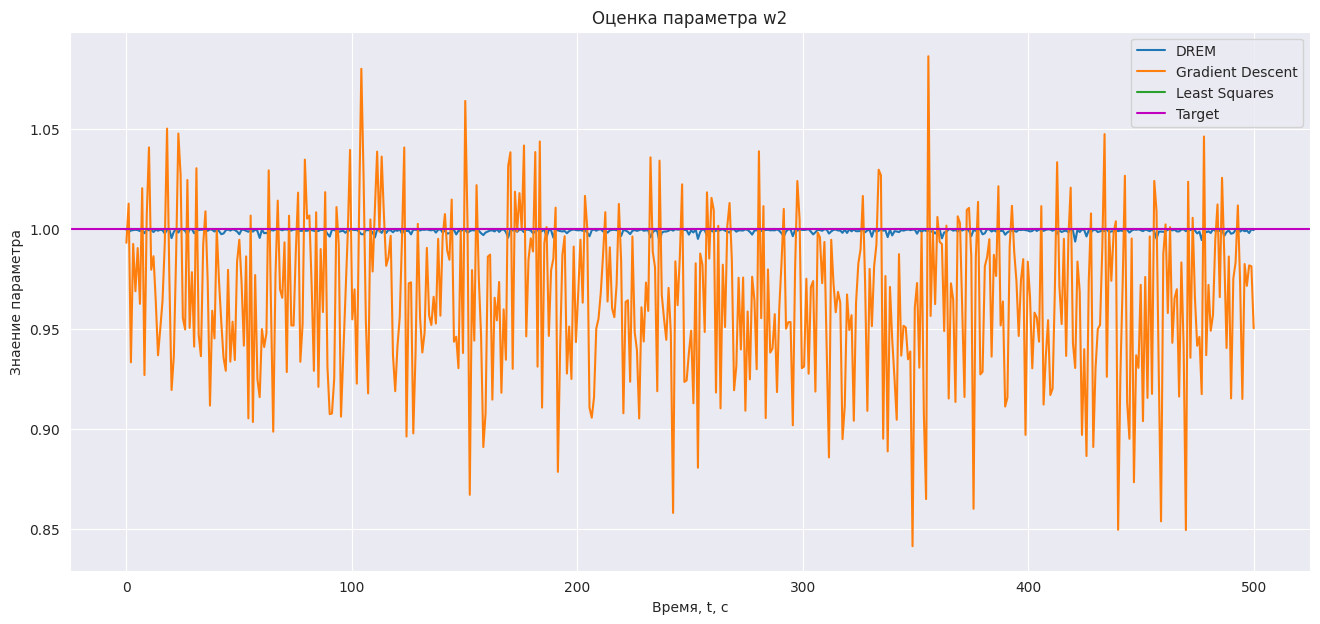

In [14]:
plt.figure(figsize=(16, 7))

for model in dict_with_results:
    plt.plot(np.linspace(0, 500, 500), dict_with_estimation[model][:, 1], label=model)
    
plt.axhline(y=1, xmin=0, xmax=5, c='m', label='Target')
plt.title('Оценка параметра w2')
plt.xlabel('Время, t, с')
plt.ylabel('Знаение параметра')
plt.legend()

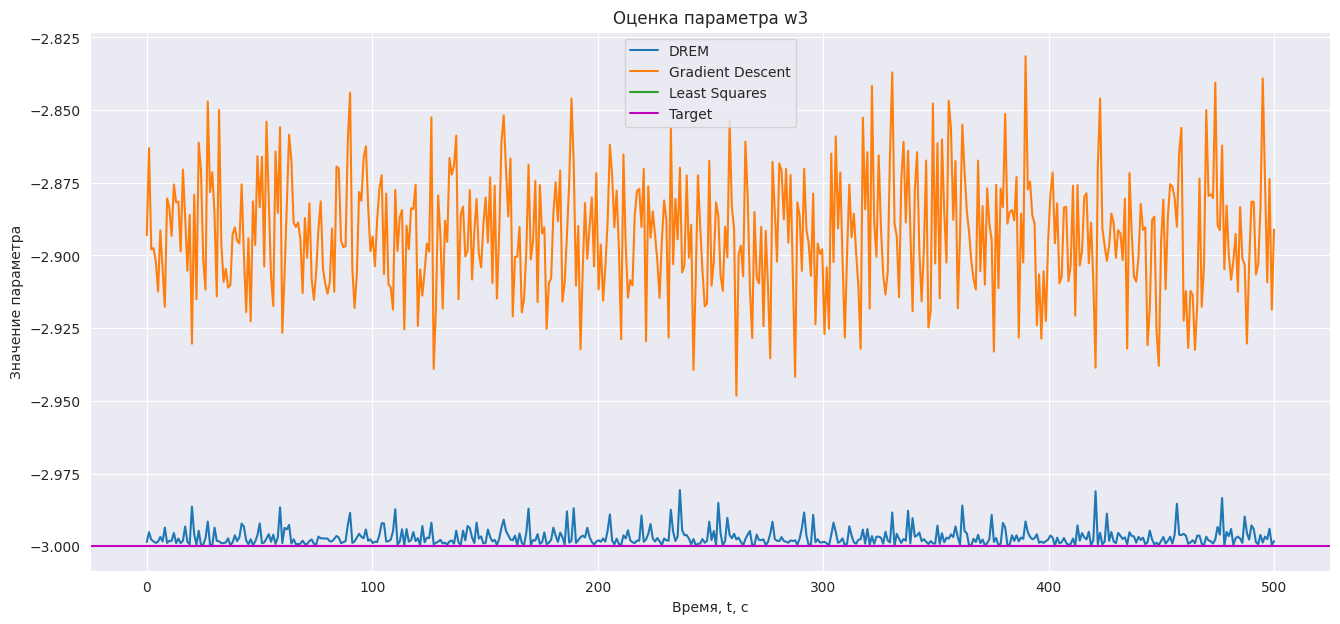

In [15]:
plt.figure(figsize=(16, 7))

for model in dict_with_results:
    plt.plot(np.linspace(0, 500, 500), dict_with_estimation[model][:, 2], label=model)
    
plt.axhline(y=-3, xmin=0, xmax=5, c='m', label='Target')
plt.title('Оценка параметра w3')
plt.xlabel('Время, t, с')
plt.ylabel('Значение параметра')
plt.legend()

In [ ]:
import json
json.dump(dict_with_estimation, 'estimation.json')
json.dump(dict_with_results, 'results.json')

## На зашумленном наборе

In [ ]:
dict_with_results = {'DREM': [], 'Gradient Descent': [], 'Least Squares': []}
dict_with_estimation = {'DREM': [], 'Gradient Descent': [], 'Least Squares': []}
dict_with_score = {'DREM': [], 'Gradient Descent': [], 'Least Squares': []}

In [ ]:
for name, model in [('Least Squares', model_ols), ('Gradient Descent', model_grad), ('DREM', model_drem)]:
    for i in range(500):
        X_patch = X_shaped_smooth[i]
        y_patch = y_shaped_smooth[i]
        if i > 1:
            dict_with_score[name].append(model.score(X_patch, y_patch))
        
        
        model.fit(X_patch, y_patch)
        dict_with_estimation[name].append(model.coef_)
        dict_with_results[name] += model.predict(X_patch).tolist()

Text(0, 0.5, 'Зависимая переменная y(t)')

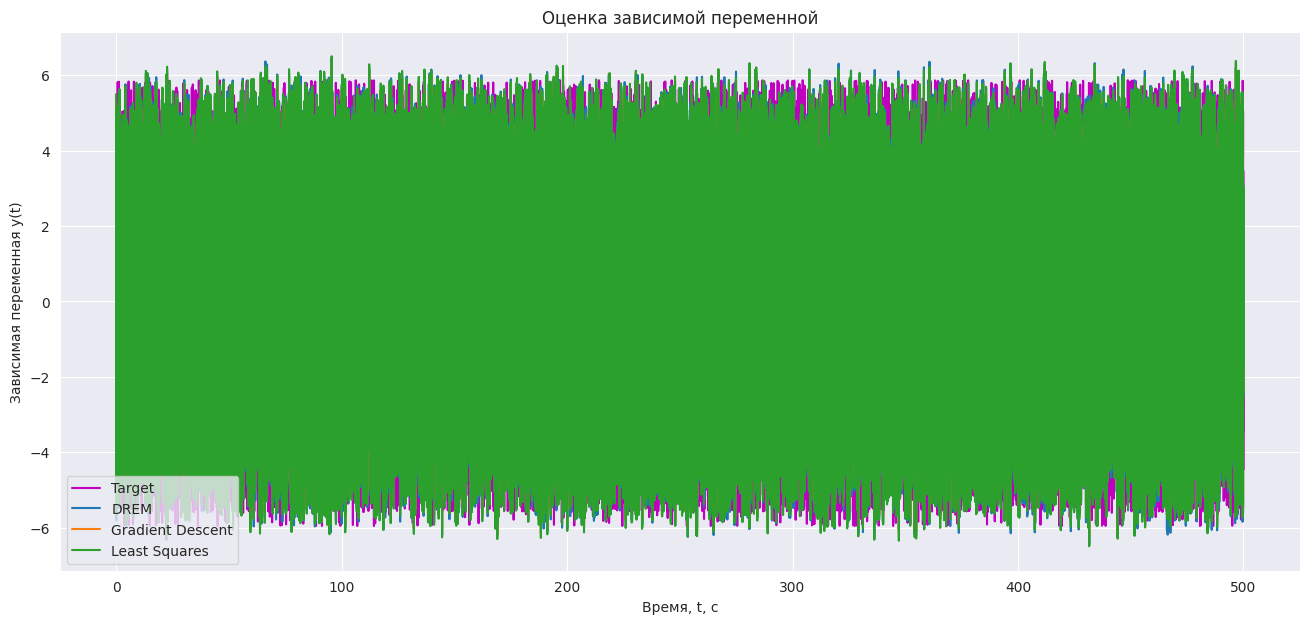

In [ ]:
plt.figure(figsize=(16, 7))
plt.plot(full_time_interval, y_full, c='m', label='Target')

for model in dict_with_results:
    plt.plot(full_time_interval, dict_with_results[model], label=model)
    
plt.title('Оценка зависимой переменной')
plt.legend()
plt.xlabel('Время, t, с')
plt.ylabel('Зависимая переменная y(t)')

Text(0, 0.5, 'Зависимая переменная y(t)')

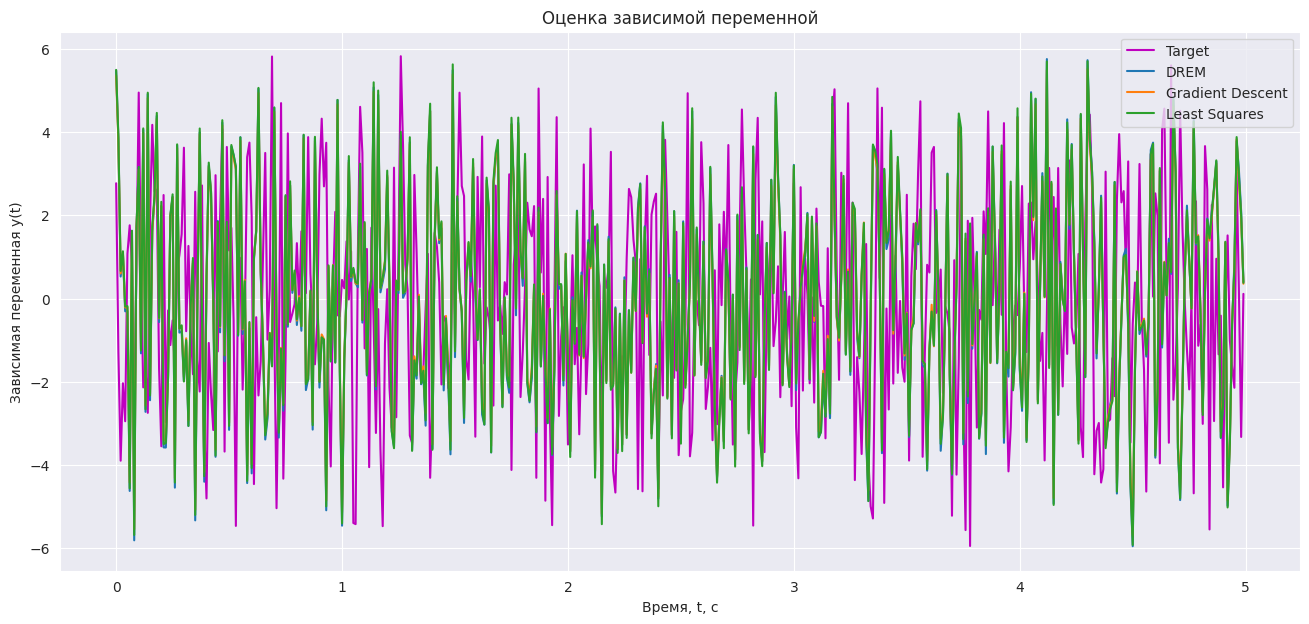

In [ ]:
plt.figure(figsize=(16, 7))
plt.plot(full_time_interval[:500], y_full[:500], c='m', label='Target')

for model in dict_with_results:
    plt.plot(full_time_interval[:500], dict_with_results[model][:500], label=model)
    
plt.title('Оценка зависимой переменной')
plt.legend()
plt.xlabel('Время, t, с')
plt.ylabel('Зависимая переменная y(t)')

In [ ]:
for model in dict_with_estimation:
    dict_with_estimation[model] = np.vstack(dict_with_estimation[model])

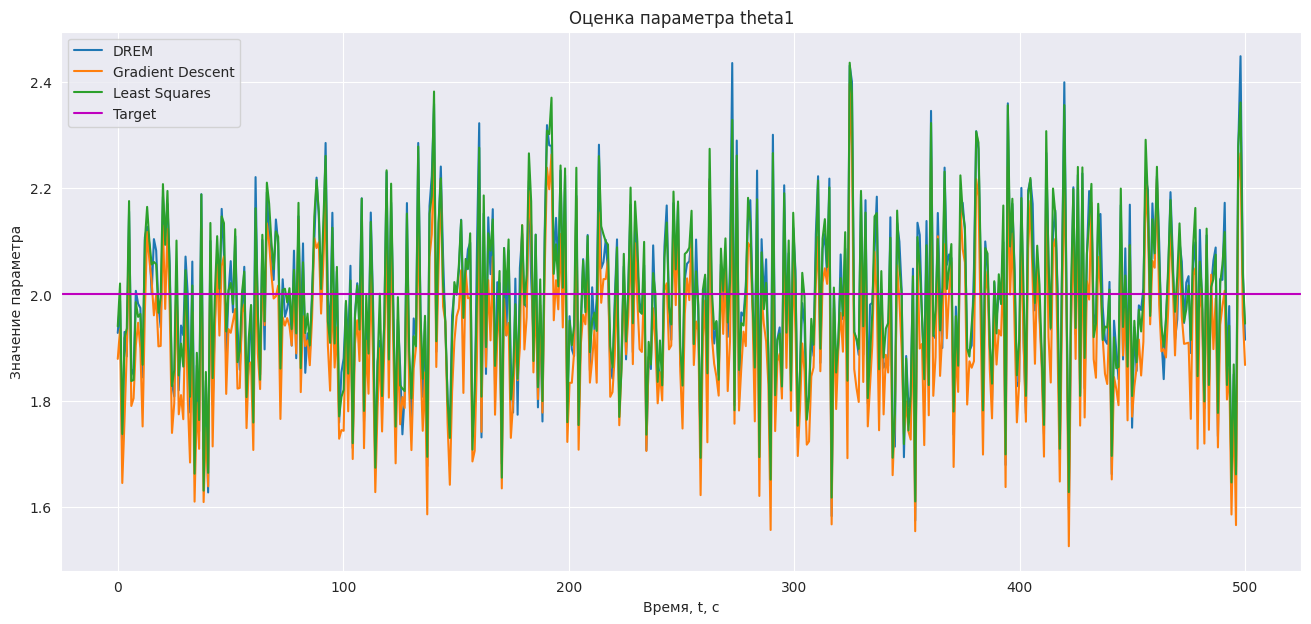

In [ ]:
plt.figure(figsize=(16, 7))

for model in dict_with_results:
    plt.plot(np.linspace(0, 500, 500), dict_with_estimation[model][:, 0], label=model)
    
plt.axhline(y=2, xmin=0, xmax=500, c='m', label='Target')
plt.title('Оценка параметра theta1')
plt.xlabel('Время, t, с')
plt.ylabel('Значение параметра')
plt.legend()

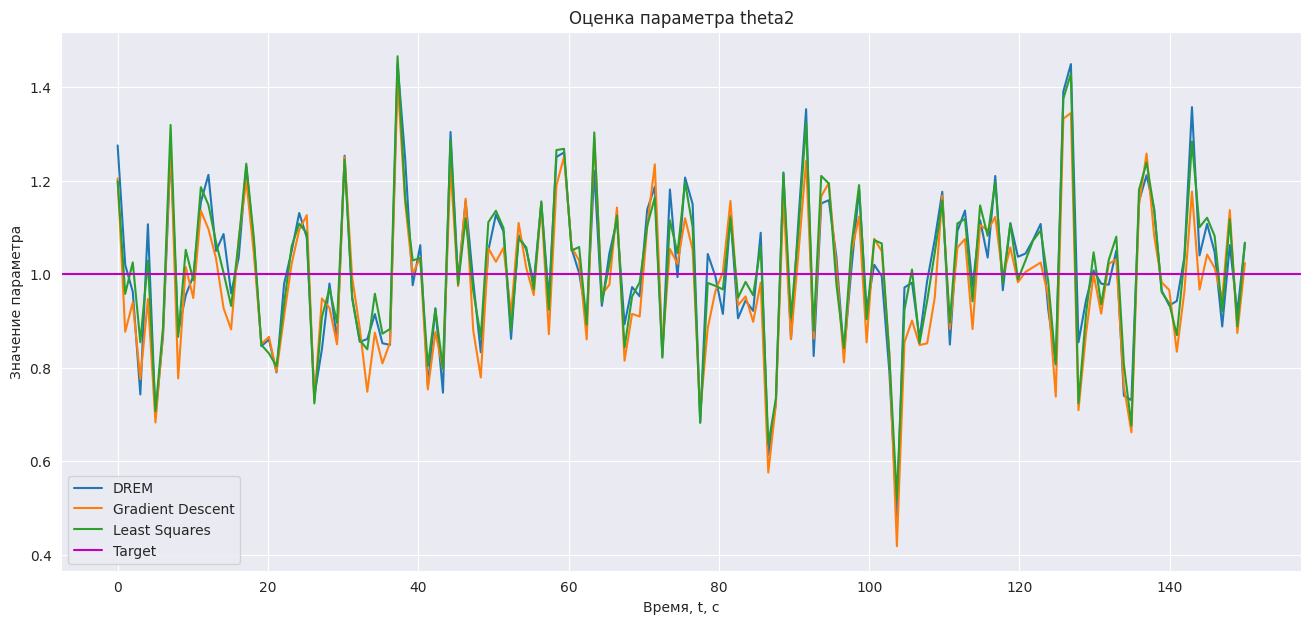

In [ ]:
plt.figure(figsize=(16, 7))

for model in dict_with_results:
    plt.plot(np.linspace(0, 150, 150), dict_with_estimation[model][:, 1][:150], label=model)
    
plt.axhline(y=1, xmin=0, xmax=150, c='m', label='Target')
plt.title('Оценка параметра theta2')
plt.xlabel('Время, t, с')
plt.ylabel('Значение параметра')
plt.legend()

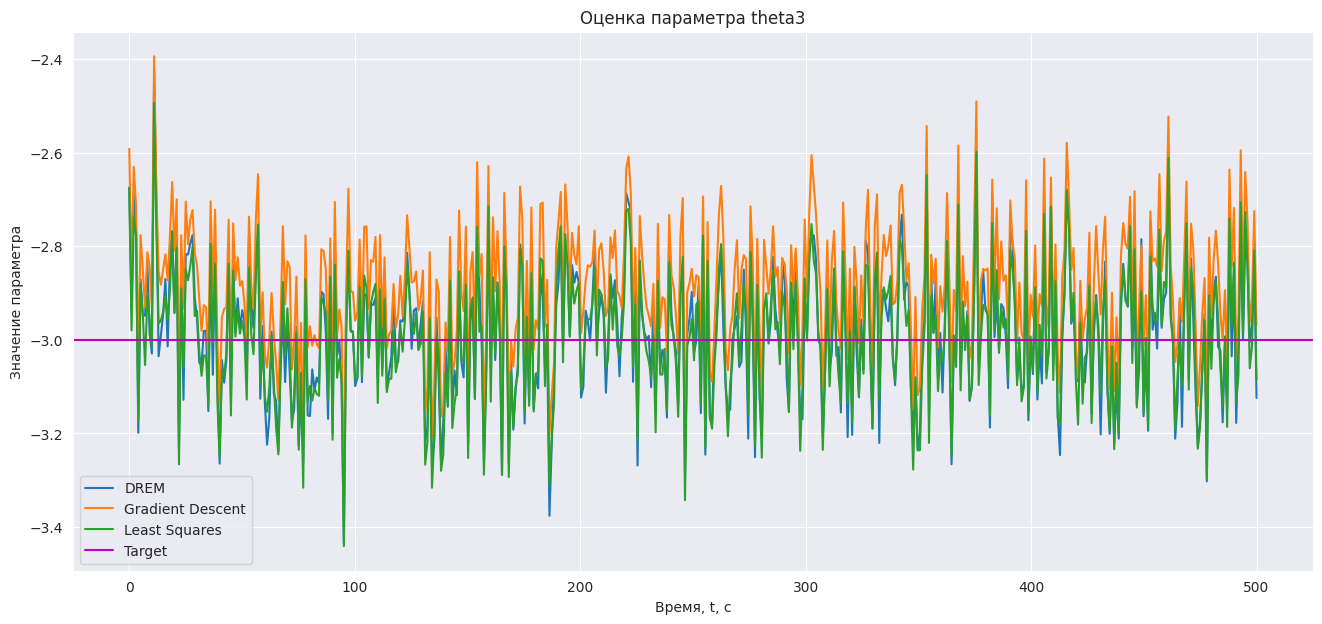

In [ ]:
plt.figure(figsize=(16, 7))

for model in dict_with_results:
    plt.plot(np.linspace(0, 500, 500), dict_with_estimation[model][:, 2], label=model)
    
plt.axhline(y=-3, xmin=0, xmax=500, c='m', label='Target')
plt.title('Оценка параметра theta3')
plt.xlabel('Время, t, с')
plt.ylabel('Значение параметра')
plt.legend()

Text(0, 0.5, 'R^2')

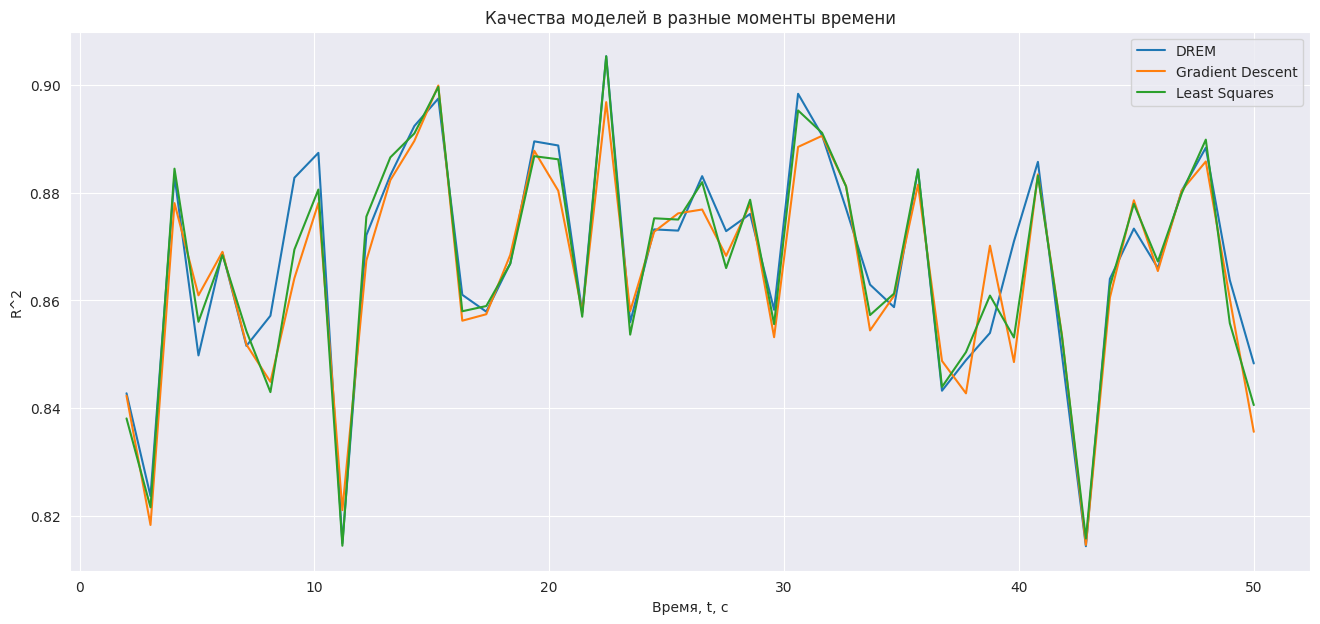

In [ ]:
plt.figure(figsize=(16, 7))


for model in dict_with_score:
    plt.plot(np.linspace(2, 50, 48), dict_with_score[model][:48], label=model)
    
plt.title('Качества моделей в разные моменты времени')
plt.legend()
plt.xlabel('Время, t, с')
plt.ylabel('R^2')

In [28]:
json.dump(dict_with_estimation, 'estimation_noise.json')
#json.dump(dict_with_result, 'results_noise.json')

AttributeError: 'str' object has no attribute 'write'

In [29]:
dict_with_results

{'DREM': [5.480473429018895,
  3.81331461882075,
  0.5304799684209563,
  1.0694009212374922,
  -0.30454513758492474,
  -0.29877493568636226,
  -4.620728165810488,
  1.6315670168444074,
  -5.807456347015938,
  1.7137329111913568,
  3.158704486377861,
  -1.3148379399704868,
  4.055792962636532,
  -2.720325961656913,
  4.915015016648599,
  -2.441641344578341,
  1.603165118380877,
  2.419431165919203,
  4.390719273940449,
  -0.5644798946102635,
  2.210625632098627,
  -3.5742380546493595,
  -3.5776100739097814,
  -1.8497329708093952,
  1.9951175210119092,
  2.4422805946124666,
  -4.541613400104009,
  3.6815401590924393,
  -0.8166224571361704,
  -0.7871029168052979,
  -1.9771055838200178,
  -1.0398016977866147,
  -3.059793813684869,
  -0.3098046561506187,
  0.8505439019253326,
  -5.3279165212573405,
  0.034832143310969114,
  3.9955064357321293,
  -0.42534623110262487,
  -4.399447053447695,
  0.3871276430364535,
  3.196314215312457,
  2.567561640430051,
  -0.19508526969868184,
  -3.8003950414

In [30]:
dict_with_estimation

{'DREM': array([[ 1.92769176,  1.27559535, -2.67427156],
        [ 1.98777773,  1.01997706, -2.93469993],
        [ 1.69584563,  0.96259297, -2.69080281],
        ...,
        [ 2.44812421,  0.89738173, -2.97016607],
        [ 2.05199642,  1.09308769, -2.81969989],
        [ 1.91480807,  0.84863687, -3.12419227]]),
 'Gradient Descent': array([[ 1.87886836,  1.20523928, -2.59176159],
        [ 1.93436714,  0.87704065, -2.85840734],
        [ 1.64543828,  0.93981898, -2.63043387],
        ...,
        [ 2.26576545,  0.90369481, -2.91313052],
        [ 1.96286876,  1.0828848 , -2.72497756],
        [ 1.86741101,  0.86887119, -2.96833086]]),
 'Least Squares': array([[ 1.93984836,  1.19905155, -2.67610768],
        [ 2.02064004,  0.95811333, -2.97990803],
        [ 1.73753156,  1.0254135 , -2.73721011],
        ...,
        [ 2.36112354,  0.93568987, -3.01231432],
        [ 2.03814771,  1.1166924 , -2.80869552],
        [ 1.94526796,  0.81422747, -3.08401972]])}

In [31]:
dict_with_score

{'DREM': [0.8427568077793698,
  0.823676149898527,
  0.8830904222329046,
  0.8497902845123774,
  0.8688758599438096,
  0.8515625282860758,
  0.8571644682856328,
  0.8827931351267856,
  0.8874126245510077,
  0.8149027751232263,
  0.8721255094393962,
  0.8832443207358371,
  0.8923938604677549,
  0.8975034804330971,
  0.8610478793006314,
  0.8579161246966878,
  0.8668747995438051,
  0.8895491566825562,
  0.8887823796767123,
  0.8577710313097868,
  0.9053615130298642,
  0.8559573311472409,
  0.8732004136207221,
  0.8729713913551491,
  0.8830877615619137,
  0.8728730240605151,
  0.8760714964408357,
  0.8582654381235658,
  0.8983831412806459,
  0.8906861345845251,
  0.8770609358561692,
  0.8629404536203736,
  0.8587594699638268,
  0.8843354347923548,
  0.8432368045001976,
  0.8489099591497854,
  0.8539610737404602,
  0.8709700405301879,
  0.8857432139381696,
  0.8499479087540507,
  0.8143545103047186,
  0.8640067699862164,
  0.873342052694259,
  0.8660179511739083,
  0.8804191151277732,
  0.